In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm

from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import *
from models import *

# torch._dynamo.config.suppress_errors = True

Load dataset:

In [2]:
data_size = 640_000
data_gen = single_random_ring(N=32)
X, y = data_gen.generate_dataset(data_size=data_size, noise=True, seed=42, device='cpu', test_return=True)

tensor([[0.4000, 0.7333, 0.5152, 0.4684, 0.8805, 0.8485]])


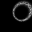

In [3]:
i = np.random.choice(data_size)
X_ = torch.Tensor(X[i].reshape(1, -1))
print(X_)
Image.fromarray((y[i] * 255).astype(np.uint8))

Test generator:

In [4]:
# load generator
model_deter = bbuffer_DGBaNR_base(data_gen.n_features, 32, 'tanh')

pre_trained_weights = torch.load('../save_data/single_random_ring/Adam_mse_loss/bbuffer_DGBaNR_base_tanh/bbuffer_DGBaNR_base_tanh_0.pt', map_location=torch.device('cpu'))
pre_trained_weights.keys()

NameError: name 'bbuffer_DGBaNR_base' is not defined

In [ ]:
dict_dict_keys = {
    'linear_layers.0.weight':'linear1.mu_weight',
    'linear_layers.0.bias':'linear1.mu_bias',
    'linear_layers.2.weight':'linear2.mu_weight',
    'linear_layers.2.bias':'linear2.mu_bias',
    'linear_layers.4.weight':'linear3.mu_weight',
    'linear_layers.4.bias':'linear3.mu_bias',
    'conv_layers.0.weight':'conv1.mu_kernel',
    'conv_layers.0.bias':'conv1.mu_bias',
    'conv_layers.1.weight':'batch_norm1.weight',
    'conv_layers.1.bias':'batch_norm1.bias',
    'conv_layers.1.running_mean':'batch_norm1.running_mean',
    'conv_layers.1.running_var':'batch_norm1.running_var',
    'conv_layers.1.num_batches_tracked':'batch_norm1.num_batches_tracked',
    'conv_layers.3.weight':'conv2.mu_kernel',
    'conv_layers.3.bias':'conv2.mu_bias',
    'conv_layers.4.weight':'batch_norm2.weight',
    'conv_layers.4.bias':'batch_norm2.bias',
    'conv_layers.4.running_mean':'batch_norm2.running_mean',
    'conv_layers.4.running_var':'batch_norm2.running_var',
    'conv_layers.4.num_batches_tracked':'batch_norm2.num_batches_tracked',
    'conv_layers.6.weight':'conv3.mu_kernel',
    'conv_layers.6.bias':'conv3.mu_bias'
}

In [5]:
# load generator
model_bayes = vessel_DGBaNR(data_gen.n_features, 32, 'tanh')

model_bayes.state_dict().keys()

odict_keys(['linear1.mu_weight', 'linear1.rho_weight', 'linear1.mu_bias', 'linear1.rho_bias', 'linear2.mu_weight', 'linear2.rho_weight', 'linear2.mu_bias', 'linear2.rho_bias', 'linear3.mu_weight', 'linear3.rho_weight', 'linear3.mu_bias', 'linear3.rho_bias', 'conv1.mu_kernel', 'conv1.rho_kernel', 'conv1.mu_bias', 'conv1.rho_bias', 'batch_norm1.weight', 'batch_norm1.bias', 'batch_norm1.running_mean', 'batch_norm1.running_var', 'batch_norm1.num_batches_tracked', 'conv2.mu_kernel', 'conv2.rho_kernel', 'conv2.mu_bias', 'conv2.rho_bias', 'batch_norm2.weight', 'batch_norm2.bias', 'batch_norm2.running_mean', 'batch_norm2.running_var', 'batch_norm2.num_batches_tracked', 'conv3.mu_kernel', 'conv3.rho_kernel', 'conv3.mu_bias', 'conv3.rho_bias'])

In [4]:
# load generator
generator = DGBaNR_2(data_gen.n_features, 32, 'tanh')
# generator = torch.compile(generator)

pre_trained_weights = torch.load(
    '../save_data/single_random_ring/Adam_LogL1Loss_5/DGBaNR_2_tanh/DGBaNR_2_tanh_25.pt',
    map_location=torch.device('cpu')
)
generator.load_state_dict(pre_trained_weights)

print(generator.eval())
print('Number of parameters:', sum(p.numel() for p in generator.parameters()))

DGBaNR_2(
  (linear_1): LinearReparameterization()
  (linear_2): LinearReparameterization()
  (conv_1): ConvTranspose2dReparameterization()
  (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): ConvTranspose2dReparameterization()
  (batch_norm_2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): ConvTranspose2dReparameterization()
  (batch_norm_3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): ConvTranspose2dReparameterization()
)
Number of parameters: 44722


0.06107150349014115


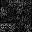

In [14]:
y_pred = generator(X_.clone())[0].detach().numpy().squeeze()
print(((y[i] - y_pred)**2).mean())
Image.fromarray((abs(y_pred) * 255).astype(np.uint8()))

In [20]:
# setting the base feature
n_samples = 10

# getting the predictions for this feature
pred_rings = np.zeros((n_samples, 32, 32))
with torch.no_grad():
    for j in range(n_samples):
        pred_rings[j] += generator(X_)[0].detach().numpy().squeeze()
pred_ring = pred_rings.sum(axis=0)

# summing the predictions
pred_prob = pred_ring * 255 / pred_ring.max()
true_prob = data_gen.gaussian_from_features(*data_gen.scaler.inverse_transform(X_)[0].tolist()) * 255

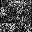

In [21]:
# predicted gaussian ring
Image.fromarray(abs(pred_prob).astype(np.uint8))

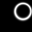

In [24]:
# true gaussian ring
Image.fromarray(true_prob.astype(np.uint8))

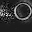

In [25]:
# difference between the rings
Image.fromarray(np.abs(true_prob - pred_prob).astype(np.uint8))

In [26]:
# MSE error
((pred_prob / pred_prob.max() - true_prob / true_prob.max())**2).mean()

0.06588017008165999

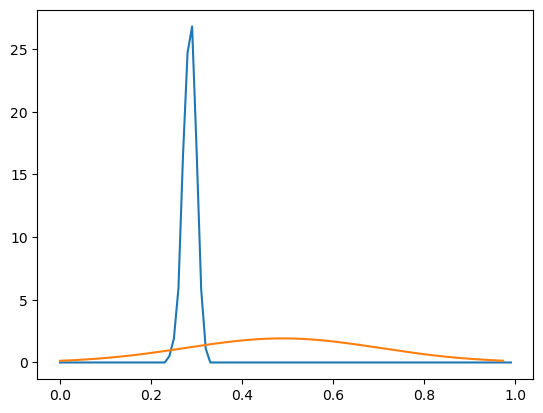

In [52]:
# getting the distribution for one pmt
pmt = (16, 17)
pred = pd.Series(pred_rings[:, pmt[0], pmt[1]])
hist = pd.Series(1, index=pd.cut(pred, np.arange(0, 1.01, 0.01))).sort_index().groupby(level=0).sum()
pred_noise = hist / (hist.sum() * 0.01)

plt.plot(np.arange(0, 1, 0.01), pred_noise)

val = np.arange(0, 2, 0.01) * true_prob[pmt] / (2 * 255)
true_pmt_distr = np.exp(-(val - true_prob[pmt] / (2 * 255))**2 / 0.3**2)
true_pmt_distr /= true_pmt_distr.sum() * 0.01 * true_prob[pmt] / (2 * 255)
plt.plot(val, true_pmt_distr)
plt.show()